In [3]:
import os
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms._presets import ImageClassification
from matplotlib import pyplot as plt

In [2]:
def DermNet(data_dir=None, transform=None):
    if not data_dir:
        cwd = os.path.dirname(__file__)
        data_dir = os.path.join(cwd, "Image_Data/DermNet")
    if not transform:
        # Use standard ImageNet normalization
        transform = ImageClassification(crop_size=224)

    return datasets.ImageFolder(data_dir, transform=transform)

In [5]:
def get_data_loaders(data_dir=None, transform=None, batch_size=64, test_split=0.2, shuffle=True, num_workers = 4, pin_memory=False):
    dataset = DermNet(data_dir, transform=transform)

    train_size = int((1 - test_split) * len(dataset))
    test_size = len(dataset) - train_size

    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory=pin_memory)
    val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory=pin_memory)

    return train_loader, val_loader

In [6]:
train_loader, val_loader = get_data_loaders()
train_features, train_labels = next(iter(train_loader))
img = train_features[0]
label = train_labels[0]
figure = plt.figure()
plt.imshow(img.movedim(0, 2))
plt.show()

NameError: name '__file__' is not defined

In [10]:
# Function to load and augment images from a directory
def augment_images(directory, num_augments):
    augmented_images = []
    for filename in os.listdir(directory):
        # Load the original image
        image_path = os.path.join(directory, filename)
        original_image = Image.open(image_path)
        
        # Apply transformations to the original image
        for _ in range(num_augments):
            # Randomly select augmentation techniques
            chosen_transforms = random.sample(transform_options, k=random.randint(1, max_transforms))
            composed_transform = transforms.Compose(chosen_transforms)
            augmented_image = composed_transform(original_image)
            augmented_images.append(transform(augmented_image))
    return augmented_images

In [11]:
# Define the subfolders containing the images
subfolders = ['Alopecia-Pictures', 'seborrheic-dermatitis-pictures', 'Psoriasis-pictures']

# Create a dictionary to store augmented images for each subfolder
augmented_images_by_subfolder = {}

In [12]:
# Define augmentation strategy
augmentation_strategy = {
    'Alopecia-Pictures': {
        'less_than_50': 6,
        'between_50_and_100': 4,
        'more_than_100': 2
    },
    'seborrheic-dermatitis-pictures': {
        'less_than_50': 6,
        'between_50_and_100': 4,
        'more_than_100': 2
    },
    'Psoriasis-pictures': {
        'less_than_50': 6,
        'between_50_and_100': 4,
        'more_than_100': 2
    }
}

In [13]:
# Augmentation techniques
transform_options = [
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5)
]
max_transforms = len(transform_options)

In [14]:
# Augment images for each subfolder based on the strategy
for subfolder in subfolders:
    subfolder_path = os.path.join(data_dir, subfolder)
    num_images = len(os.listdir(subfolder_path))
    num_augments = None
    if num_images < 50:
        num_augments = augmentation_strategy[subfolder]['less_than_50']
    elif 50 <= num_images <= 100:
        num_augments = augmentation_strategy[subfolder]['between_50_and_100']
    else:
        num_augments = augmentation_strategy[subfolder]['more_than_100']
        
    augmented_images = augment_images(subfolder_path, num_augments=num_augments)
    augmented_images_by_subfolder[subfolder] = augmented_images

In [15]:
# Convert the augmented images to torch tensors
augmented_images_tensors_by_subfolder = {}
for subfolder, images in augmented_images_by_subfolder.items():
    augmented_images_tensors_by_subfolder[subfolder] = torch.stack(images)

# Display the size of tensors for each subfolder
for subfolder, tensors in augmented_images_tensors_by_subfolder.items():
    print(f"Subfolder: {subfolder}, Tensor size: {tensors.size()}")

Subfolder: Alopecia-Pictures, Tensor size: torch.Size([328, 3, 224, 224])
Subfolder: seborrheic-dermatitis-pictures, Tensor size: torch.Size([240, 3, 224, 224])
Subfolder: Psoriasis-pictures, Tensor size: torch.Size([202, 3, 224, 224])



Showing images from subfolder: Alopecia-Pictures


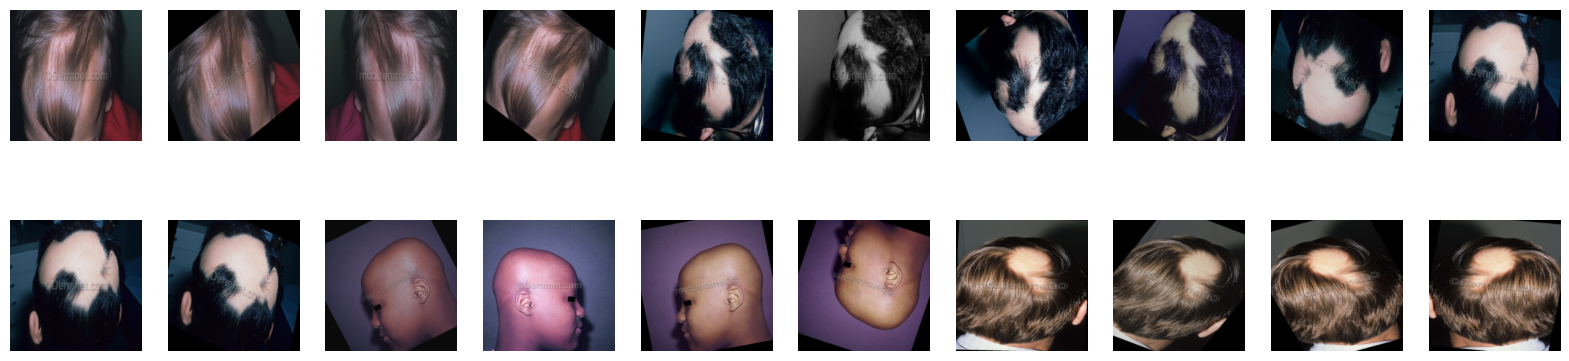


Showing images from subfolder: seborrheic-dermatitis-pictures


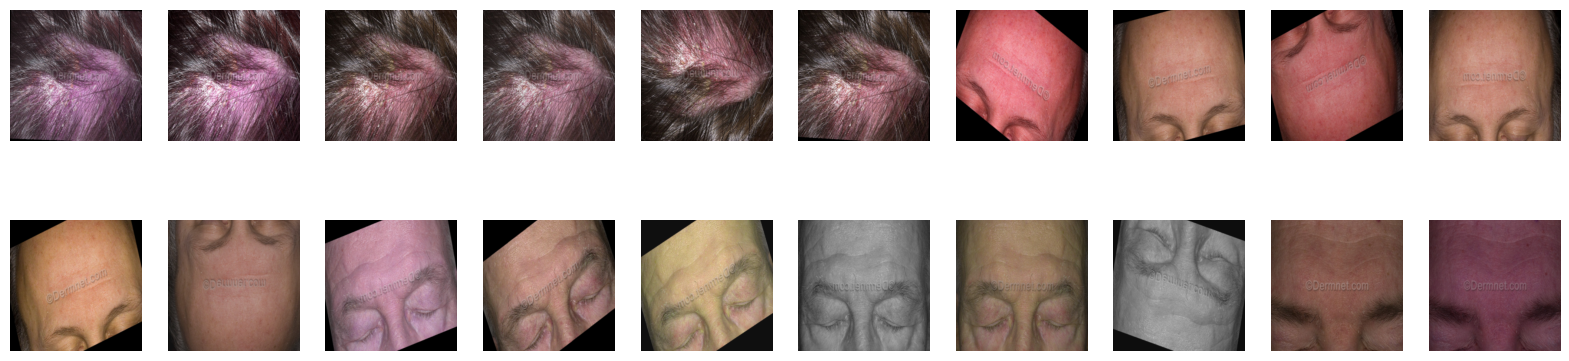


Showing images from subfolder: Psoriasis-pictures


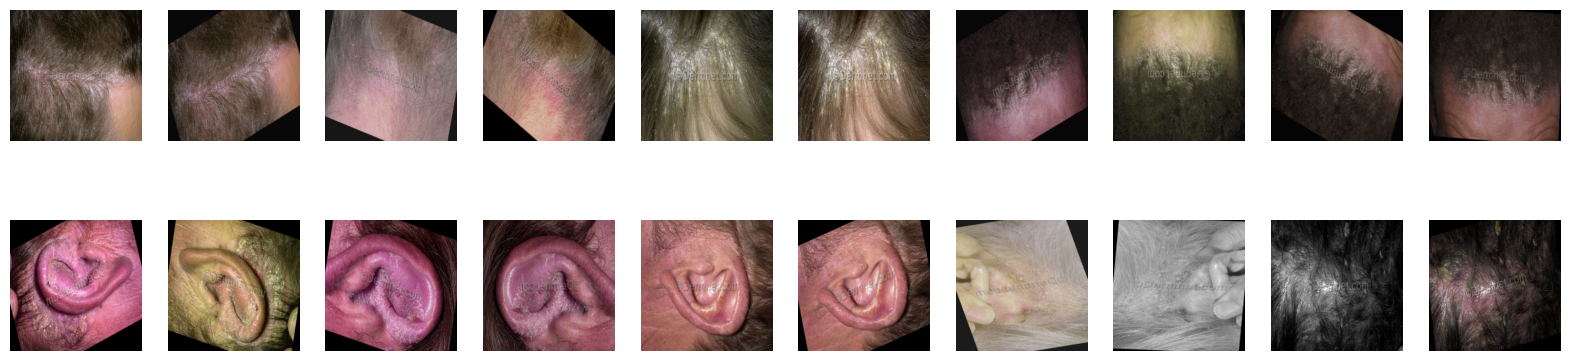

In [16]:
# Display 20 pictures from each subfolder
for subfolder, images in augmented_images_by_subfolder.items():
    print(f"\nShowing images from subfolder: {subfolder}")
    plt.figure(figsize=(20, 5))
    for i in range(20):  # Displaying 20 images from each subfolder
        plt.subplot(2, 10, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))
        plt.axis('off')
    plt.show()

In [17]:
# Combine all augmented images and create labels
all_images = torch.cat([torch.stack(images) for images in augmented_images_by_subfolder.values()], dim=0)
num_classes = len(subfolders)
all_labels = torch.tensor(sum([[i] * len(images) for i, images in enumerate(augmented_images_by_subfolder.values())], []))

In [18]:
# Split data into training and validation sets
dataset = list(zip(all_images, all_labels))
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [19]:
# Define DataLoader for training and validation sets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Check the sizes of training and validation sets
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

Training set size: 616
Validation set size: 154


In [24]:
model = models.resnet34(pretrained=True)
print(model)

c:\Users\wisea\anaconda3\envs\Tensorflow\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
c:\Users\wisea\anaconda3\envs\Tensorflow\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [31]:
# Freeze all the parameters in the model
for param in model.parameters():
    param.requires_grad = False

In [27]:
model.fc = nn.Linear(model.fc.in_features, num_classes)
print(model.fc)

Linear(in_features=512, out_features=3, bias=True)


In [26]:
device = torch.device("gpu" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [35]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
print(optimizer)
print(criterion)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
CrossEntropyLoss()


In [37]:
num_epochs = 50

for epoch in range(num_epochs):
    # Training loop
    model.train()  # Set model to training mode
    train_loss = 0.0
    correct_preds = 0  # Define correct_preds inside the training loop
    total_preds = 0  # Define total_preds inside the training loop
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Track training loss and accuracy
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)
    
    # Calculate average training loss and accuracy
    avg_train_loss = train_loss / len(train_loader)
    
    if total_preds != 0:
        train_accuracy = correct_preds / total_preds
    else:
        train_accuracy = 0.0
    
    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct_preds = 0  # Reset correct_preds for validation
    total_preds = 0  # Reset total_preds for validation
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            val_loss += criterion(outputs, labels).item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)
    
    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / len(val_loader)
    
    if total_preds != 0:
        val_accuracy = correct_preds / total_preds
    else:
        val_accuracy = 0.0
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy*100:.2f}%, '
          f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy*100:.2f}%')


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn